# Example usage of NRSur3dq8_RD fit.

In [1]:
# Silence an annoying lal warning
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

In [2]:
import surfinBH

In [3]:
fit_name = 'NRSur3dq8_RD'

## Load the fit, this only needs to be done once at the start of a script

In [4]:
fit = surfinBH.LoadFits(fit_name)

Loaded NRSur3dq8_RD fit.


## Read the documentation

In [5]:
help(fit)

Help on Fit3dq8_RD in module surfinBH._fit_evaluators.fit_3dq8_RD object:

class Fit3dq8_RD(surfinBH.surfinBH.SurFinBH)
 |  Fit3dq8_RD(name)
 |
 |  A class for the NRSur3dq8_RD model presented in Magana Zertuche et al.,
 |  arxiv:TODO.
 |
 |  This model predicts the final mass mf, final spin chif, and
 |  complex QNM amplitudes A_(l,m,n,p), for the remnants of
 |  nonprecessing binary black hole systems. The fits are done using
 |  Gaussian Process Regression (GPR) and also provide an error
 |  estimate along with the fit value.
 |
 |  This model has been trained in the parameter space:
 |      q <= 8, |chiAz| <= 0.8, |chiBz| <= 0.8
 |
 |  However, it extrapolates reasonably to:
 |      q <= 10, |chiAz| <= 1, |chiBz| <= 1
 |
 |  =========================================================================
 |  Usage:
 |
 |  import surfinBH
 |
 |  # Load the fit
 |  fit = surfinBH.LoadFits('NRSur3dq8_RD')
 |
 |  We provide the following call methods:
 |      # remnant mass and 1-sigma error 

## Evaluate the fits

In [6]:
q = 4.3             # Mass ratio q>=1
chiA = [0,0,0.6]    # Spin of larger BH (z-direction only)
chiB = [0,0,-0.7]   # Spin of smaller BH (z-direction only)

## Evaluate the fits and GPR error estimate.

# remnant mass and 1-sigma error estimate
mf, mf_err = fit.mf(q, chiA, chiB)

# remnant spin and 1-sigma error estimate
chif, chif_err = fit.chif(q, chiA, chiB)

# remnant mass, spin, and all available modes
mf, chif, QNM_dict, mf_err, chif_err, QNM_err_dict = fit.all(q, chiA, chiB)
print(QNM_dict.keys())
QNM_dict[(2,2,0,1)]

dict_keys([(2, 2, 0, 1), (2, -2, 0, -1), (2, 2, 1, 1), (2, -2, 1, -1), (2, 0, 0, 1), (2, 0, 0, -1), (4, 4, 0, 1), (4, -4, 0, -1), (3, 2, 0, 1), (3, -2, 0, -1)])


(0.12748926488933388+0.026256919397940833j)

In [7]:
# Only request a subset of modes
modes=[ (2, 2, 0, 1), (2, -2, 0, -1), (2, 0, 0, 1), (2, 0, 0, -1) ]
mf, chif, QNM_dict, mf_err, chif_err, QNM_err_dict = fit.all(q, chiA, chiB, modes=modes)
print(QNM_dict.keys())

dict_keys([(2, 2, 0, 1), (2, -2, 0, -1), (2, 0, 0, 1), (2, 0, 0, -1)])


## Reconstruct superrest frame waveform from some modes (requires `qnm` package)

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
import qnm

In [10]:
qnm.download_data() # Only need to do this once

Trying to fetch https://duetosymmetry.com/files/qnm/data-0.4.0.tar.bz2


data-0.4.0.tar.bz2: 94.6MB [00:02, 35.8MB/s]                                                                                                      


Trying to decompress file /home/leo/.cache/qnm/data-0.4.0.tar.bz2
Data directory /home/leo/.cache/qnm/data contains 860 pickle files


In [10]:
from example_utils import qnm_from_tuple

In [11]:
?qnm_from_tuple

Signature: qnm_from_tuple(tup, chi, M, s=-2)
Docstring:
Get frequency and spherical-spheroidal mixing from qnm package

Parameters
----------
tup : tuple 
    Index (ell,m,n,sign) of QNM

chi : float
    The dimensionless spin of the black hole, 0. <= chi < 1.

M : float
    The mass of the remnant black hole, M > 0.

s : int, optional [Default: -2]

Returns
-------
omega: complex
    Frequency of QNM, in units of inverse initial total mass M

C: complex ndarray
    Spherical-spheroidal decomposition coefficient array

ells: ndarray 
    List of ell values for the spherical-spheroidal mixing array
File:      /central/home/leo/src/surfinBH/examples/example_utils.py
Type:      function

In [12]:
q = 4.3             # Mass ratio q>=1
chiA = [0,0,0.6]    # Spin of larger BH (z-direction only)
chiB = [0,0,-0.7]   # Spin of smaller BH (z-direction only)

mf, chif, QNM_dict, mf_err, chif_err, QNM_err_dict = fit.all(q, chiA, chiB)

###

# All times in units of initial M
t     = np.arange(0., 100., 0.05)
t_0   = 20.
t_ref = 20.

h_mode_labels = [(l,m) for l in [2,3,4] for m in np.arange(-l, l+1)]

h = {}
for (ell_prime, m_prime, n, sign), A in QNM_dict.items():
    omega, C, ells = qnm_from_tuple((ell_prime, m_prime, n, sign), 
                                     chif, mf)

    expiwt = np.exp( -1.j * omega * (t - t_ref))
    expiwt[ t < t_0 ] = 0.
    for h_l, h_m in h_mode_labels:
        if (h_m == m_prime):
            c_l = C[ells == h_l]
            if (len(c_l) > 0):
                c_l = c_l[0]
                h[(h_l, h_m)] = c_l * A * expiwt + h.get((h_l, h_m), 0.)

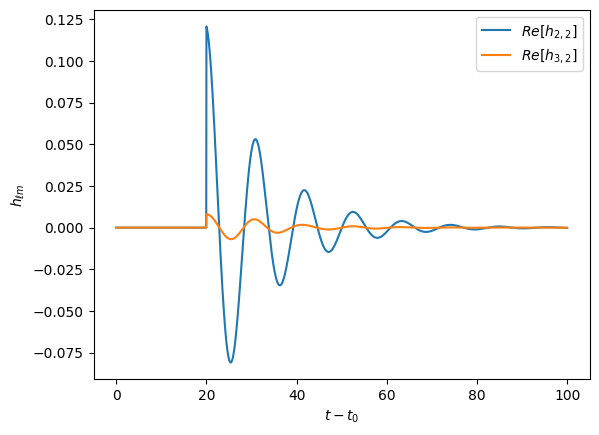

In [15]:
# Spherical (3,2) mode contains contributions from (3,2,0,1) QNM and mixing from (2,2,0,1) QNM
plt.plot(t, h[(2,2)].real, label='$Re[h_{2,2}]$')
plt.plot(t, h[(3,2)].real, label='$Re[h_{3,2}]$')
plt.xlabel('$t-t_0$')
plt.ylabel('$h_{\\ell m}$')
plt.legend()
plt.show()